In [1]:
import pandas as pd
from datetime import datetime, timedelta
import statsmodels.api as sm
import numpy as np

# time series - statsmodels 
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 

# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

### Forecast energy supply for the next two days 

Long-term forecasts not the issue, rather short-term, intra-day supplies

What was the supply today, controlling for weather, use that as a starting point to forecast the next two days

Requires forecasting weather and other short-term effects affecting supply

In [2]:
def datetime_range(start, end, delta):
    '''Need to create time date series'''
    current = start
    while current < end:
        yield current
        current += delta
        
dts = [dt.strftime('%Y-%m-%d %H:%M') for dt in 
       datetime_range(datetime(2020, 4, 1, 0), datetime(2021, 4, 1, 0), 
       timedelta(minutes=15))]

### Read in data

              Total
count  35040.000000
mean      39.316823
std       65.282022
min        0.000000
25%        0.000000
50%        0.362500
75%       60.577500
max      360.375000
Total    float64
dt        object
dtype: object


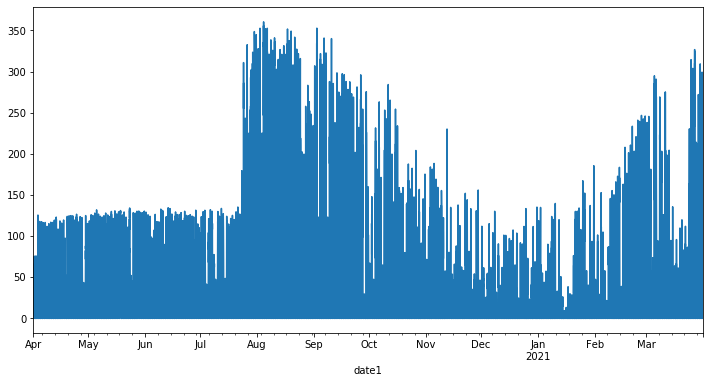

In [3]:
#read in data
dt1 = pd.read_csv('../data/production_raw.csv', dayfirst = True, parse_dates=True, index_col='DateTime')
dt1.rename(columns = {'DateTime': 'Date'}, inplace = True)
dt1['dt'] = dts
dt1['date1'] = pd.to_datetime(dt1['dt'])
dt1.set_index('date1', inplace = True)

dt1['Total'].plot(figsize = (12, 6))

print(dt1.describe())
print(dt1.dtypes)


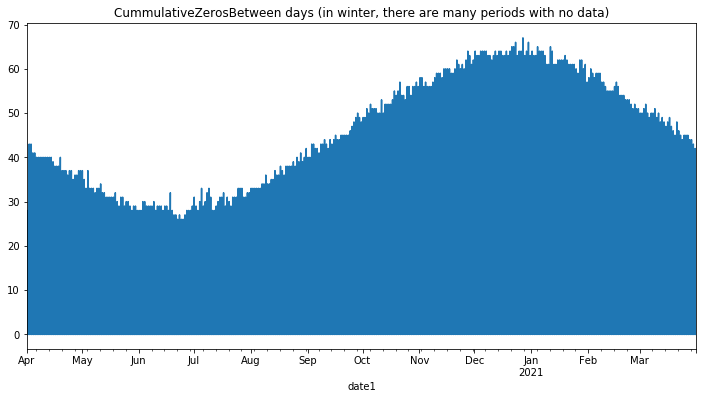

In [4]:
# cmZeros
a = dt1['Total'].shift().eq(0)
b = a.cumsum()
dt1['CmZerosBetween'] = b.sub(b.mask(a).ffill().fillna(0)).astype(int)
dt1['CmZerosBetween'].iloc[0:].plot(figsize = (12, 6), title = "CummulativeZerosBetween days (in winter, there are many periods with no data)")

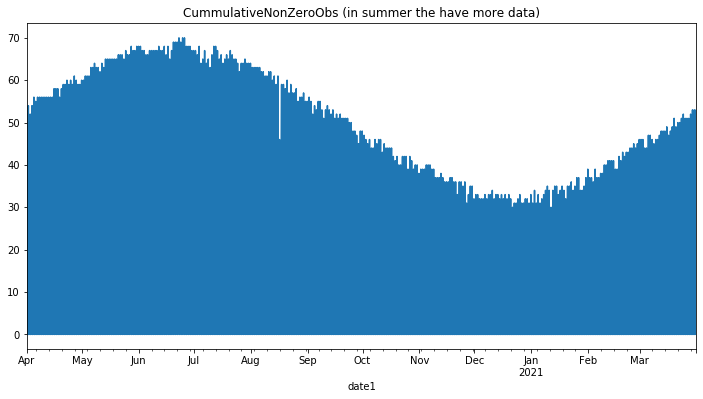

In [5]:
# cmNonZeros
a = dt1['Total'].ne(0)
b = a.cumsum()
dt1['CmNonZeros'] = b.sub(b.mask(a).ffill().fillna(0)).astype(int)
dt1['CmNonZeros'].iloc[0:].plot(figsize = (12, 6), title = 'CummulativeNonZeroObs (in summer the have more data)')

### Import radiation as a possible exogenous variable

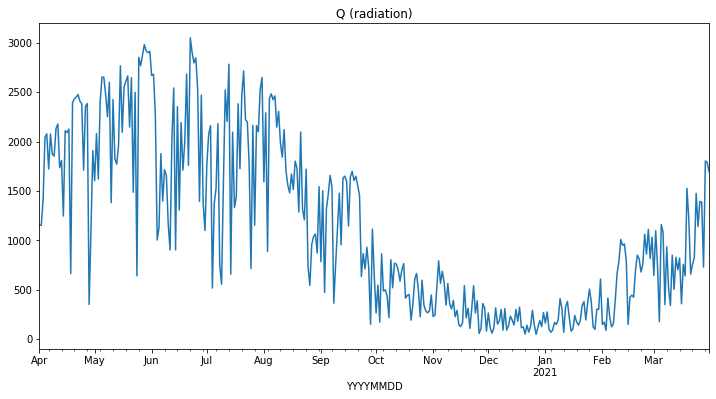

In [6]:
rad1 = pd.read_csv('../data/Radiation.csv', sep = ';')
rad1['YYYYMMDD'] = pd.to_datetime(rad1['YYYYMMDD'],  format='%Y%m%d')
rad1.set_index('YYYYMMDD', inplace = True, drop = True)
rad1.columns = rad1.columns.str.strip()

# select range
start_date = '2020-04-01'
end_date   = '2021-03-31'
rad1['Day'] = rad1.index.floor('D')
rad1.head()
mask = (rad1['Day'] >= start_date) & (rad1['Day'] <= end_date)
rad2 = rad1[mask]
rad2.head()

rad2['Q'].plot(figsize = (12, 6), title = 'Q (radiation)')

### Holts-Winter

In [72]:
seriesAll = dt1['Total']


(960,)


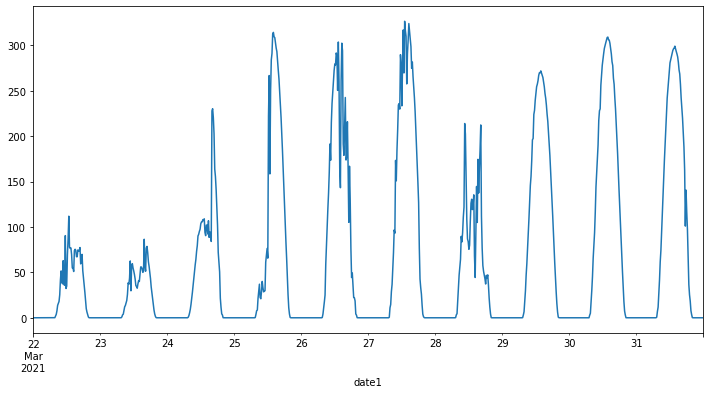

In [93]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
lastNumObs = 96 * 10
data = seriesAll[-lastNumObs:]
print(data.shape)
data.plot(figsize=(12,6))

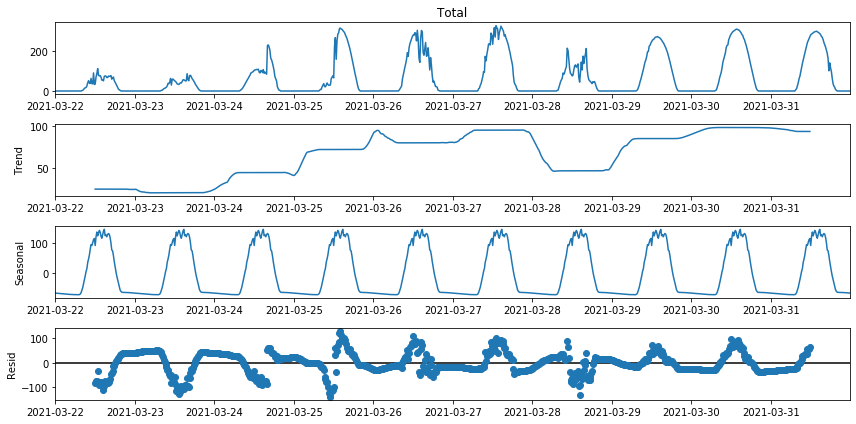

In [24]:
from matplotlib.pyplot import figure
plt.rc("figure", figsize=(12, 6))
plt.rc("font", size=10)

decompose_result = seasonal_decompose(data,model='additive', period = 96)
decompose_result.plot()

m = 96
alpha = 1/(2*m)

In [ ]:
#https://stats.stackexchange.com/questions/127337/explain-the-croston-method-of-r
#https://analyticsindiamag.com/hands-on-guide-to-time-series-analysis-using-simple-exponential-smoothing-in-python/#:~:text=Simple%20Exponential%20Smoothing%20(SES)%20is,statsmodel%20using%20pip%20install%20statsmodel.&text=Simple%20Exponential%20Smoothing%20is%20defined,where%20we%20will%20import%20it.
#https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html
#https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html

In [74]:
aust = data
aust.head()

date1
2021-03-22 00:00:00    0.0
2021-03-22 00:15:00    0.0
2021-03-22 00:30:00    0.0
2021-03-22 00:45:00    0.0
2021-03-22 01:00:00    0.0
Name: Total, dtype: float64

In [75]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

%matplotlib inline

fit1 = ExponentialSmoothing(
    aust,
    seasonal_periods=96,
    trend="add",
    seasonal="add",
    initialization_method="estimated",
).fit()

/home/jeff/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


In [76]:
fit2 = ExponentialSmoothing(
    aust,
    seasonal_periods=96,
    trend="add",
    initialization_method="estimated",
).fit()

/home/jeff/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


In [77]:
fit3 = ExponentialSmoothing(
    aust,
    seasonal_periods=4,
    trend="add",
    seasonal="add",
    damped_trend=True,
    initialization_method="estimated",
).fit()

/home/jeff/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


In [78]:
fit4 = ExponentialSmoothing(
    aust,
    seasonal_periods=4,
    trend="add",
    damped_trend=True,
    initialization_method="estimated",
).fit()

/home/jeff/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


In [79]:
results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "SSE"]
)
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]
results["Additive"] = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"] = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

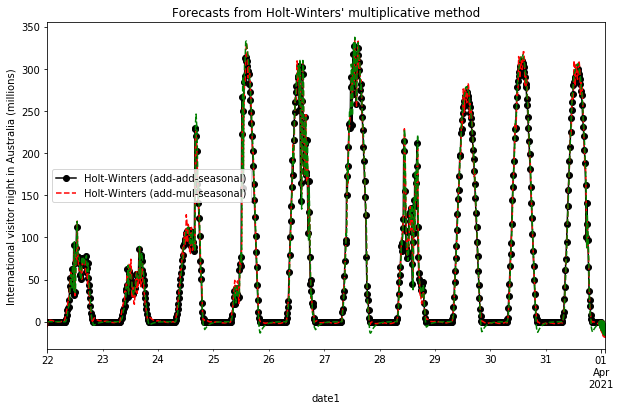

Figure 7.6: Forecasting international visitor nights in Australia using Holt-Winters method with both additive and multiplicative seasonality.


,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,0.927494,0.942466,0.872091,0.909669
$\beta$,0.043078,0.127565,0.133258,0.127020
$\phi$,NaN,NaN,0.979598,0.909089
$\gamma$,0.008675,NaN,0.000572,NaN
$l_0$,34.075966,-0.052252,0.159570,-0.004251
$b_0$,1.621592,0.048419,-0.002269,0.003942
SSE,233975.233382,292876.129319,286703.031223,283183.371650


In [80]:
ax = aust.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts from Holt-Winters' multiplicative method",
)
ax.set_ylabel("International visitor night in Australia (millions)")
ax.set_xlabel("Year")
fit1.fittedvalues.plot(ax=ax, style="--", color="red")
fit2.fittedvalues.plot(ax=ax, style="--", color="green")

fit1.forecast(8).rename("Holt-Winters (add-add-seasonal)").plot(
    ax=ax, style="--", marker="o", color="red", legend=True
)
fit2.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)

plt.show()
print(
    "Figure 7.6: Forecasting international visitor nights in Australia using Holt-Winters method with both additive and multiplicative seasonality."
)

results

In [155]:
data = dt1.iloc[-lastNumObs:]
data = data['Total']
data.head()

date1
2021-03-22 00:00:00    0.0
2021-03-22 00:15:00    0.0
2021-03-22 00:30:00    0.0
2021-03-22 00:45:00    0.0
2021-03-22 01:00:00    0.0
Name: Total, dtype: float64

In [161]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast

#data.index.freq = data.index.inferred_freq
data = pd.Series(
    data, index=pd.date_range("2021-03-22 00:00:00", periods=len(data), freq="15min"), name="Total"
)

In [168]:

s=sm.tsa.seasonal_decompose(data, period = 96)
s

In [169]:
stlf = STLForecast(data, ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"), seasonal=96)
stlf_res = stlf.fit()

forecast = stlf_res.forecast(96)

ValueError: freq T not understood. Please report if you think this is in error.

In [108]:
plt.plot(data['Total'])
plt.plot(forecast)
plt.show()

ValueError: freq T not understood. Please report if you think this is in error.

In [90]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast

from statsmodels.datasets import elec_equip as ds

elec_equip = ds.load().data
elec_equip

,STS.M.I7.W.TOVT.NS0016.4.000
DATE,
1995-01-01,66.19
1995-02-01,65.15
1995-03-01,74.48
1995-04-01,71.26
1995-05-01,67.63
...,...
2016-01-01,92.73
2016-02-01,95.49
2016-03-01,110.57


In [91]:
elec_equip.index.freq = elec_equip.index.inferred_freq
elec_equip

,STS.M.I7.W.TOVT.NS0016.4.000
DATE,
1995-01-01,66.19
1995-02-01,65.15
1995-03-01,74.48
1995-04-01,71.26
1995-05-01,67.63
...,...
2016-01-01,92.73
2016-02-01,95.49
2016-03-01,110.57


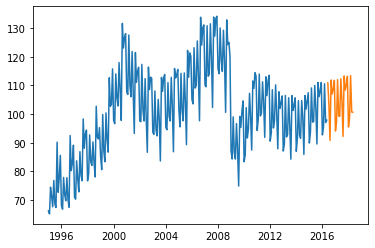

In [89]:
stlf = STLForecast(elec_equip, ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"))
stlf_res = stlf.fit()

forecast = stlf_res.forecast(24)
plt.plot(elec_equip)
plt.plot(forecast)
plt.show()

In [ ]:
data['HWES1'] = SimpleExpSmoothing(data['Total']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues
data[['Total','HWES1']].plot(title='Holt Winters Single Exponential Smoothing')

In [ ]:
data['HWES2_ADD'] = ExponentialSmoothing(data['Total'],trend='add',seasonal_periods=96).fit().fittedvalues
data[['Total','HWES2_ADD']].plot(title='Holt Winters Double Exponential Smoothing: Additive');

In [ ]:
data.asfreq('15T')

In [ ]:
train_data = data[:(lastNumObs-96)]
test_data = data[(lastNumObs-96):]

In [ ]:
fitted_model = ExponentialSmoothing(train_data['Total'], trend = 'add', seasonal='add',seasonal_periods=96).fit()
test_predictions = fitted_model.forecast(96)
test_predictions.index = testindex

In [ ]:
train_data['Total'].plot(legend=True,label='Train')
test_data['Total'].plot(legend=True,label='Test',figsize=(12,8))
test_predictions.plot(legend=True,label='Prediction')
plt.title('Train, Test and Predicted Test using Holt Winters')

In [ ]:
ins1 = SimpleExpSmoothing(data).fit(smoothing_level=0.2,optimized=False)
ins_cast1 = ins1.forecast(3).rename('alpha=0.2')

ins2 = SimpleExpSmoothing(data).fit(smoothing_level=0.8,optimized=False)
ins_cast2 = ins2.forecast(3).rename('alpha=0.8')

#Third Instance
ins3 = SimpleExpSmoothing(data).fit()
ins_cast3 = ins3.forecast(3).rename('alpha=%s'%ins3.model.params['smoothing_level'])

#After creating model we will visualize the plot
ax = data.plot(marker='o', color='black', figsize=(12,8), legend=True)

#Plot for alpha =0.2
ins_cast1.plot(marker='+', ax=ax, color='blue', legend=True)
ins1.fittedvalues.plot(marker='+', ax=ax, color='blue')

#Plot for alpha = 0.8
ins_cast2.plot(marker='o', ax=ax, color='red', legend=True)
ins2.fittedvalues.plot(marker='o', ax=ax, color='red')

#Plot for alpha=Optimized by statsmodel
ins_cast3.plot(marker='*', ax=ax, color='green', legend=True)
ins3.fittedvalues.plot(marker='*', ax=ax, color='green')


In [ ]:
model = ExponentialSmoothing(train)
results = model.fit()
predicted = results.forecast(120)
predicted.plot()

In [ ]:
sub1 = trc[-20:]
print(sub1)
test_size = 5
train = sub1[:-test_size]
print(train)
test = sub1[-test_size:]
test

In [ ]:
split = 5
train_size = len(trc[-5000:1])

In [ ]:
4*24*2

#### 

In [ ]:
y_train = trc[0:].values

In [ ]:
arima_model = pmdarima.auto_arima(y_train, start_p=2, d=0, start_q=0, max_p=3, max_d=2, max_q=3, seasonal=False)
order = arima_model.order
order

In [ ]:
predDataFrame['ARIMA'] = pd.DataFrame(arima_model.predict(n_periods = predPeriod-1), index = y_test.index).values

# predict based on model
model2 =  sm.tsa.arima.ARIMA(y_train, order=order).fit()

In [ ]:
model2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
trc.values
trc.index

In [ ]:
X = trc.index
#X = np.reshape(X, (len(X), 1))
y = trc.values
X

In [ ]:
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)
plt.plot(y)
plt.plot(trend)
plt.legend(['data', 'trend'])
plt.show()

In [ ]:
import statsmodels.api as sm
from statsmodels.compat import lzip
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)


dt1['Q'] = np.repeat(rad2.values[:,0], 24 * 4, axis=0)
# Fit and summarize OLS model
dt1.head()
dt1['Q_2'] = dt1['Q'] * dt1['Q']
dt1['Q_3'] = dt1['Q_2'] * dt1['Q']

In [ ]:
exog1 = dt1[['Q', 'Q_2', 'Q_3']].values
exog1 = np.array(exog1, dtype=float)
exog1

In [ ]:
exog1 = sm.add_constant(exog1, prepend=True)

endog1 = dt1['Total'].values

mod = sm.OLS(endog1, exog1)
res = mod.fit()
print(res.summary())

In [ ]:
from pandas import read_csv
from matplotlib import pyplot
from numpy import polyfit

series = dt1['Total'].values
# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = [i%365 for i in range(0, len(series))]
y = series.values
degree = 4
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(X)):
	value = coef[-1]
	for d in range(degree):
		value += X[i]**(degree-d) * coef[d]
	curve.append(value)
# plot curve over original data
pyplot.plot(series.values)
pyplot.plot(curve, color='red', linewidth=3)
pyplot.show()

In [ ]:
dt2 = dt1[dt1.index >= '2020-08-01']
dtMonth = dt2.groupby(pd.Grouper(freq='D')).sum()
dtMonth['Total'].plot(figsize = (20, 18))

### What are interday patterns, do they change through time?

In [ ]:
dt3 = dt1.drop(columns = ['Date', 'dt', 'CmZerosBetween', 'CmNonZeros'])
dt3.head()
dt3['2020-08-04'].plot(figsize = (20, 13))

In [ ]:
dt3['Day'] = dt3.index.floor('D')

start_date = '2021-01-15'
end_date   = '2021-01-25'

mask = (dt3['Day'] >= start_date) & (dt3['Day'] <= end_date)
dt4 = dt3[mask]

grp1 = dt4.groupby('Day')

for key, dat in grp1:
    dat['Total'].plot(figsize = (20, 8))
    

In [ ]:
start_date = '2020-08-15'
end_date   = '2020-08-25'

mask = (dt3['Day'] >= start_date) & (dt3['Day'] <= end_date)
dt4 = dt3[mask]

grp1 = dt4.groupby('Day')

for key, dat in grp1:
    dat['Total'].plot(figsize = (20, 8))

### Split data

In [ ]:
split = int(len(dt1) * 0.5)
train = dt1.iloc[:split].copy()
dtMonth = train.groupby(pd.Grouper(freq='D')).sum()
dtMonth['Total'].plot(figsize = (20, 18))

In [ ]:
# Add a dummy for data until Aug

In [ ]:
qdata = pd.read_csv('../data/Radiation.csv', sep = ';')
qdata

In [ ]:
pd.to_datetime(qdata['YYYYMMDD'], format = "%Y%m%d").dt.strftime('%Y-%m-%d')